In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np
import itertools

from sklearn.metrics import mean_squared_error

from utils.generative import Gaussian
from utils.generative import MixtureDistribution
 
from utils.visualisations import plot_confusion_matrix
from utils.visualisations import plot_weight_matrix

from utils.barycentric import draw_func_contours
from utils.barycentric import get_converging_lines
from utils.barycentric import plot_converging_lines_pvalues

def perfect_calibration(x, a, b, mg):
    x_mirror = x.copy()
    x_mirror[:,1] = 2*a/(1-b) - x_mirror[:,1]
    qq = mg.pdf(x)/(mg.pdf(x)+mg.pdf(x_mirror))
    qqx = qq.reshape(-1,1)
    qqxm = 1-qqx
    qc = qqx * mg.posterior(x) + qqxm * mg.posterior(x_mirror)
    return qc

In [2]:
plt.rcParams['figure.figsize'] = (16, 5)

n_samples = 100000

# Square grid precision
grid_levels = 200

# Barycentric grid precision
bc_grid_levels = 50
bc_grid_subdiv = 5

# 1. Mixture of Multivariate Gaussian distribution

prior = 0.33, Distribution = Gaussian(mean = [0 0], cov = [[1 0]
 [0 1]])
prior = 0.33, Distribution = Gaussian(mean = [1 1], cov = [[ 0.5  -0.25]
 [-0.25  0.5 ]])
prior = 0.33, Distribution = Gaussian(mean = [-1  1], cov = [[0.5  0.25]
 [0.25 0.5 ]])



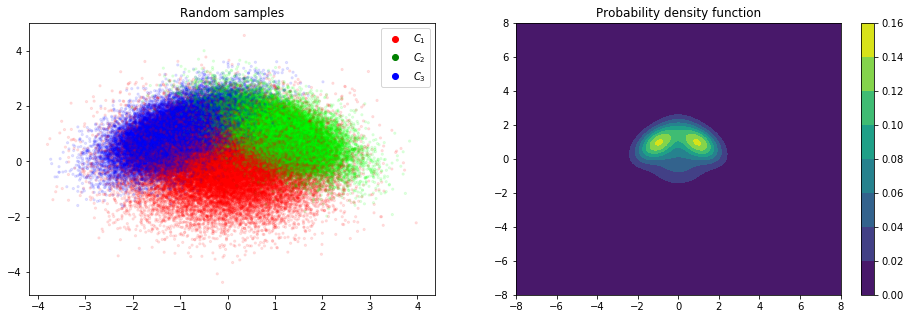

In [3]:
np.random.seed(42)

prior = [1/3, 1/3, 1/3]
a = 1
b = 0.5
c = 0.25

x_grid = np.linspace(-8, 8, grid_levels)
y_grid = np.linspace(-8, 8, grid_levels)

mg = MixtureDistribution(priors=prior,
                         distributions=[Gaussian([0, 0], [[1, 0], [0, 1]]),
                                        Gaussian([+a, +a], [[+b, -c], [-c, +b]]),
                                        Gaussian([-a, +a], [[+b, +c], [+c, +b]])])

#mg = MixtureDistribution(priors=prior,
#                         distributions=[Gaussian([-1, 0], [[1, 0.5], [0.5, 1]]),
#                                        Gaussian([0, 0], [[1, 0.5], [0.5, 1]]),
#                                        Gaussian([+1, 0], [[1, 0.5], [0.5, 1]])])

print(mg)

X, Y_bin = mg.sample(n_samples)
Y = np.argmax(Y_bin, axis=1)

X_test, Y_bin_test = mg.sample(n_samples)
Y_test = np.argmax(Y_bin_test, axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Random samples')
ax1.scatter(X[:,0], X[:,1], s=5, color=Y_bin, alpha=0.1)

c1_mark = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label=r'$C_1$')
c2_mark = mlines.Line2D([], [], color='green', marker='o', linestyle='None', label=r'$C_2$')
c3_mark = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label=r'$C_3$')

ax1.legend(handles=[c1_mark, c2_mark, c3_mark])

xx, yy = np.meshgrid(x_grid, y_grid)
z = mg.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability density function')
contour = ax2.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
fig.colorbar(contour)

## 1.a. Individual probability density functions

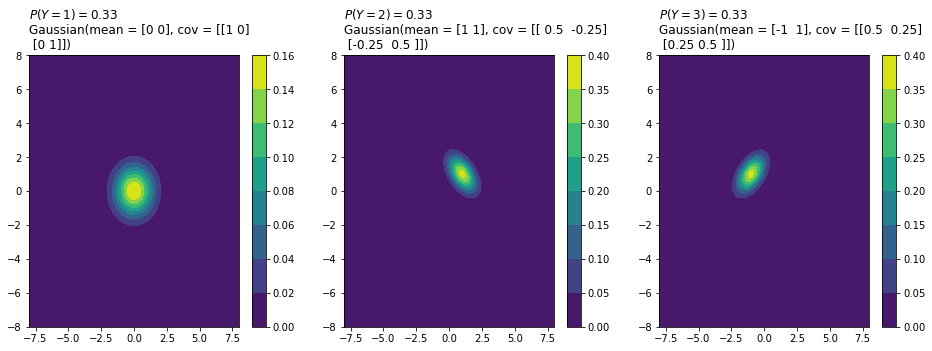

In [4]:
def plot_individual_pdfs(class_dist):
    fig = plt.figure()
    xx, yy = np.meshgrid(x_grid, y_grid)

    for i, (p, d) in enumerate(zip(class_dist.priors, class_dist.distributions)):
        z = d.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)
        
        ax = fig.add_subplot(1, len(class_dist.distributions), i+1)
        ax.set_title('$P(Y={})={:.2f}$\n{}'.format(i+1, p, str(d)), loc='left')
        contour = ax.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
        fig.colorbar(contour)
        
plot_individual_pdfs(mg)

## 1.b. Individual posterior probabilities

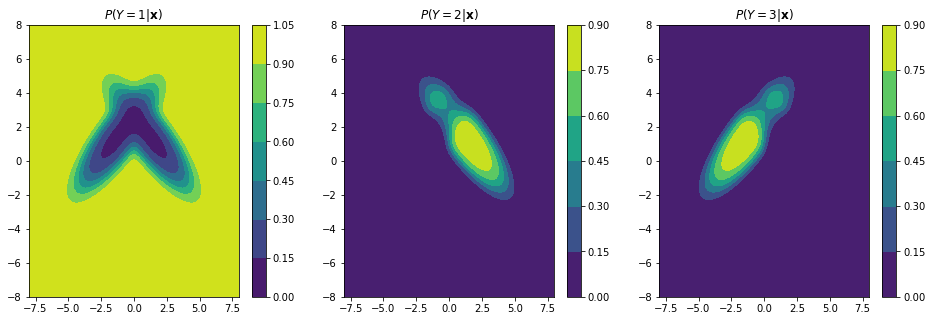

In [5]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
    
for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

# 2. Training a Gaussian Naive Bayes

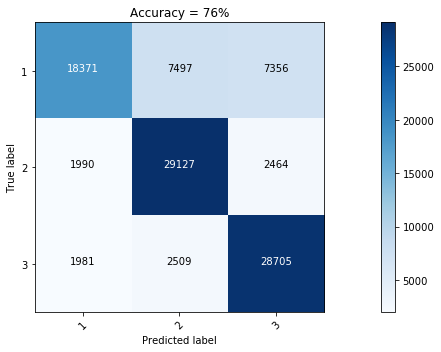

In [6]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
Y_nb = gnb.fit(X, Y).predict(X)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, Y_nb)

plot_confusion_matrix(cm, classes=['1', '2', '3'], title="Accuracy = {:.0f}%".format((Y == Y_nb).mean()*100))

## 2.a. Individual predicted posterior probabilities

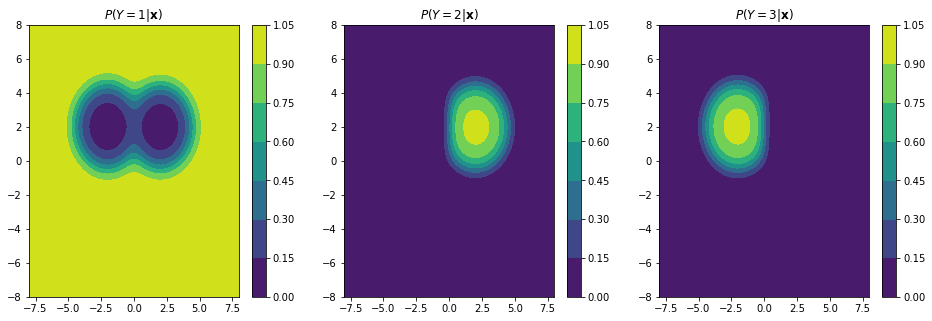

In [7]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = gnb.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)

for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

## 2.b. Histogram of predicted probabilities for each Actual class

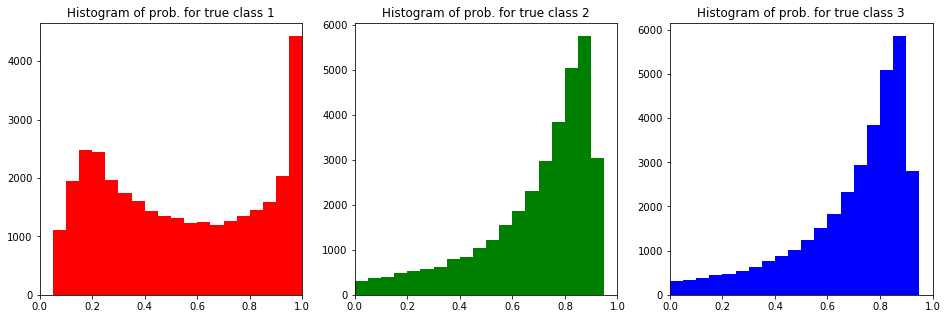

In [8]:
P_nb_test = gnb.predict_proba(X_test)

fig = plt.figure()
colors = ['red', 'green', 'blue']
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('Histogram of prob. for true class {}'.format(i+1))
    ax.hist(P_nb_test[Y_test == i, i], bins=20, range=(0, 1), color=colors[i])
    ax.set_xlim(0, 1)

## 2.c. 2D Histogram of paired predicted probabilities for each Actual class

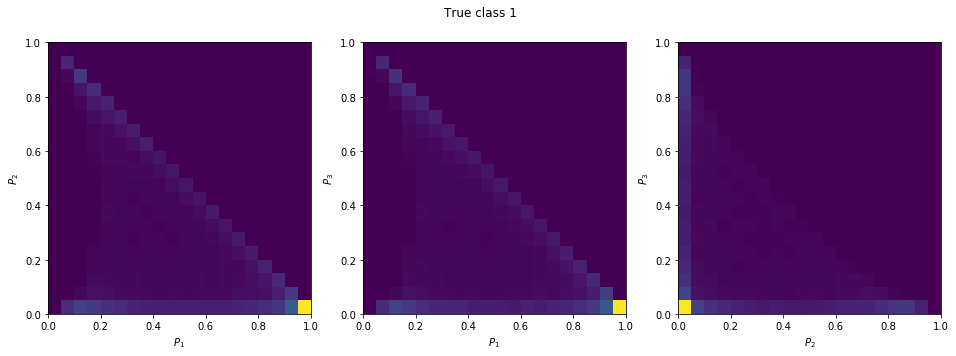

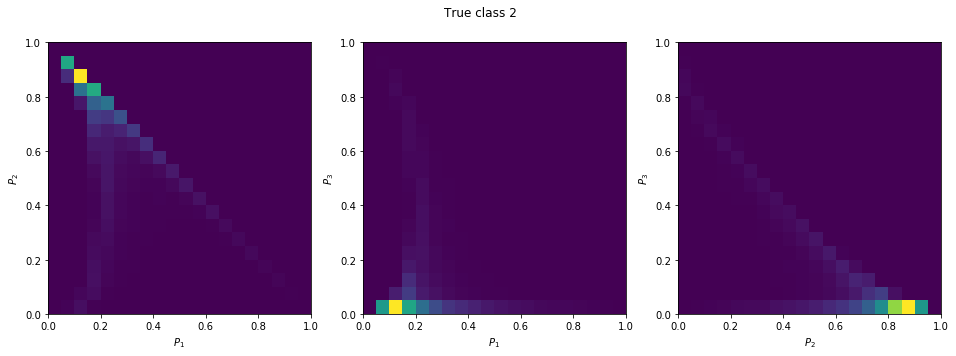

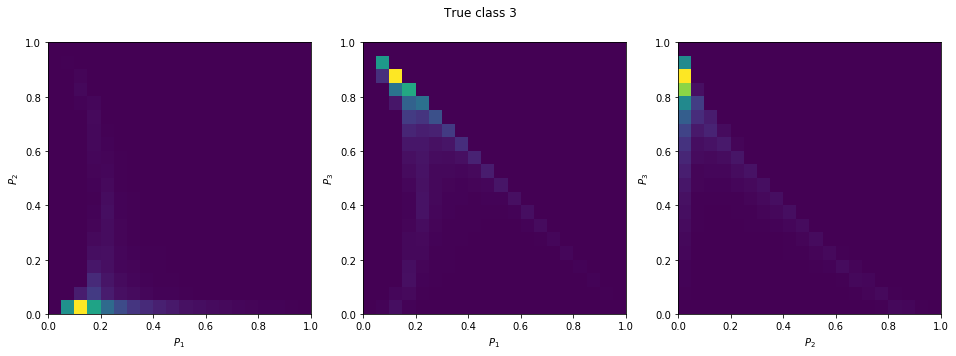

In [9]:
from itertools import combinations

for true_class in [0, 1, 2]:
    fig = plt.figure()
    fig.suptitle('True class {}'.format(true_class+1))
    for i, (cx, cy) in enumerate(combinations([0, 1, 2], 2)):
        ax = fig.add_subplot(1, 3, i+1)
        ax.hist2d(P_nb_test[Y_test == true_class, cx], P_nb_test[Y_test == true_class, cy],
                  bins=20, range=[[0, 1], [0, 1]])
        ax.set_xlabel(r'$P_{}$'.format(cx+1))
        ax.set_ylabel(r'$P_{}$'.format(cy+1))

## 2.d. Predicted probabilities for each sample

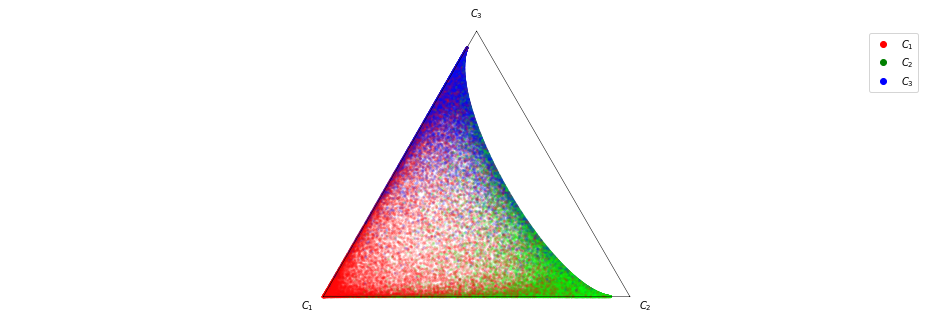

In [10]:
from utils.barycentric import draw_tri_samples

draw_tri_samples(P_nb_test, Y_bin_test, s=15, marker='.', alpha=0.1, handles=[c1_mark, c2_mark, c3_mark])

# 2.appendix.1. Training my own Naive Bayes (generative)

The previous Gaussian Naive Bayes from Section 2 is the [default in Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). The following one is my own implementation which computes prior, mean and variance per each feature and class, and then creates a Mixture of Gaussians from which it is possible to sample and obtain posterior probabilities.

The benefit of this code is that it is simple and we can possibly visualise additional parts of it.

At first sight, the performance is the same 75%. 

prior = 0.33, Distribution = Gaussian(mean = [ 0.00525263 -0.00544587], cov = [[0.99694685 0.        ]
 [0.         1.00108623]])
prior = 0.34, Distribution = Gaussian(mean = [1.0044092  0.99654039], cov = [[0.70574377 0.        ]
 [0.         0.7064369 ]])
prior = 0.33, Distribution = Gaussian(mean = [-0.99818992  0.99915604], cov = [[0.70764419 0.        ]
 [0.         0.71148631]])



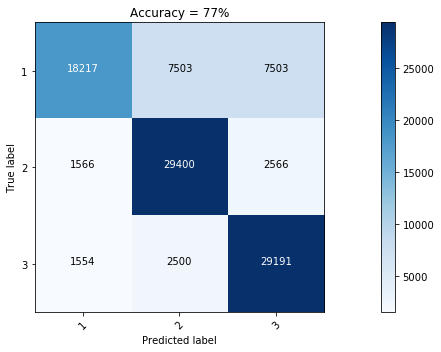

In [11]:
classes = np.unique(Y)
n_classes = len(classes)
n_features = X.shape[1]

nb_priors = np.zeros((n_classes))
nb_means = np.zeros((n_classes, n_features))
nb_variances = np.zeros((n_classes, n_features))
for i in classes:
    nb_priors[i] = np.mean(Y == i)
    for j in range(n_features):
        nb_means[i, j] = np.mean(X[Y == i, j])
        nb_variances[i, j] = np.std(X[Y == i, j])
        
nb_dist = MixtureDistribution(priors=nb_priors,
                              distributions=[Gaussian(nb_means[i], np.diag(nb_variances[i])) for i in range(n_classes)])

print(nb_dist)

P_nb_test = np.argmax(nb_dist.posterior(X_test), axis=1)

cm = confusion_matrix(Y_test, P_nb_test)

plot_confusion_matrix(cm, classes=['1', '2', '3'], title="Accuracy = {:.0f}%".format((Y_test == P_nb_test).mean()*100))

## 2.appendix.2. Generating samples from my Naive Bayes

The benefit of our code is that we can generate new samples, and see the true probability density function of the learned Mixture of Gaussians.

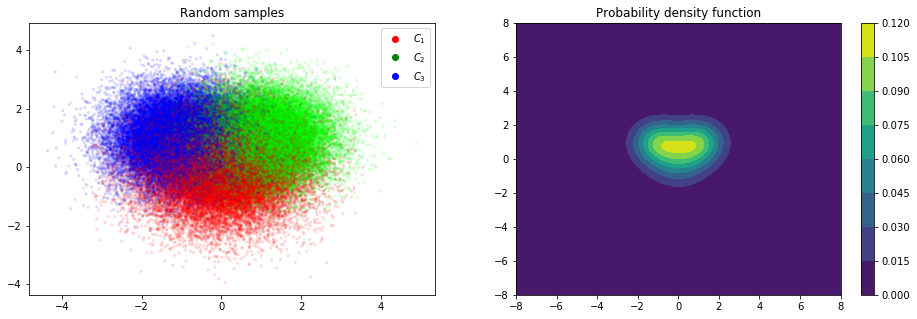

In [12]:
nb_X, nb_Y_bin = nb_dist.sample(n_samples)

nb_Y = np.argmax(nb_Y_bin, axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Random samples')
ax1.scatter(nb_X[:,0], nb_X[:,1], s=5, color=nb_Y_bin, alpha=0.1)

ax1.legend(handles=[c1_mark, c2_mark, c3_mark])

xx, yy = np.meshgrid(x_grid, y_grid)
z = nb_dist.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability density function')
contour = ax2.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
fig.colorbar(contour)

## 2.appendix.3. Likelihoods of individual Gaussians

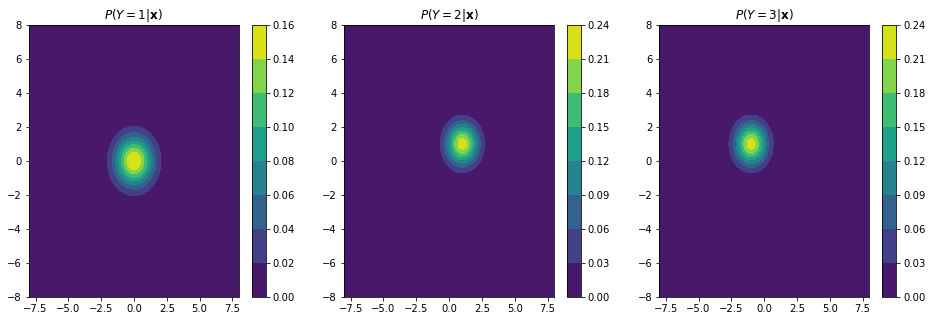

In [13]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = nb_dist.likelihoods(np.vstack([xx.flatten(), yy.flatten()]).T)

for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

# 3. Calibration with Multinomial Logistic Regression in log scores

In [14]:
P_nb = gnb.predict_proba(X)
P_nb_test = gnb.predict_proba(X_test)

Calibrator parameters
{
  "C": 1.0,
  "tol": 0.0001,
  "warm_start": false,
  "max_iter": 100,
  "solver": "lbfgs",
  "class_weight": null,
  "intercept_scaling": 1,
  "random_state": null,
  "n_jobs": null,
  "multi_class": "multinomial",
  "fit_intercept": true,
  "penalty": "l2",
  "verbose": 0,
  "dual": false
}


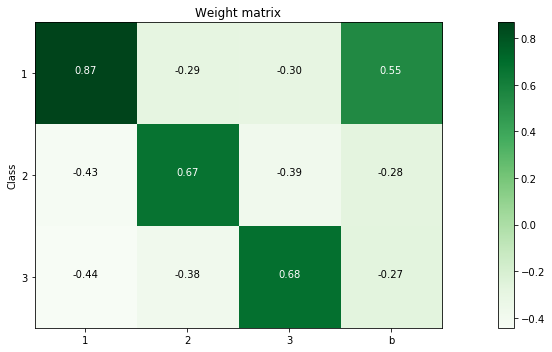

In [15]:
eps = np.finfo(P_nb.dtype).eps
log_P_nb = np.log(np.clip(P_nb, eps, 1))

from sklearn.linear_model import LogisticRegression
calibrator = LogisticRegression(C=1.0, solver='lbfgs', multi_class='multinomial').fit(log_P_nb, Y)

#from sklearn.neural_network import MLPClassifier
#calibrator =  MLPClassifier(solver='lbfgs', alpha=1e-5,
#                            hidden_layer_sizes=(10), random_state=1).fit(log_pred, Y)

print('Calibrator parameters')
import json
print(json.dumps(calibrator.get_params(), indent=2))

log_P_nb_test = np.log(np.clip(P_nb_test, eps, 1))

P_cal_test = calibrator.predict_proba(log_P_nb_test)

Y_cal_test = calibrator.predict(log_P_nb_test)

if hasattr(calibrator, 'coef_'):
    plot_weight_matrix(calibrator.coef_, calibrator.intercept_, classes=['1', '2', '3'])
elif hasattr(calibrator, 'coefs_'):
    plot_weight_matrix(calibrator.coefs_[-1].T, calibrator.intercepts_[-1], classes=['1', '2', '3'])

Uncalibrated Brier score = 1.16e-01
Calibrated Brier score = 1.14e-01
Perfect cal Brier score = 1.10e-01
Irreducible Brier score = 1.09e-01


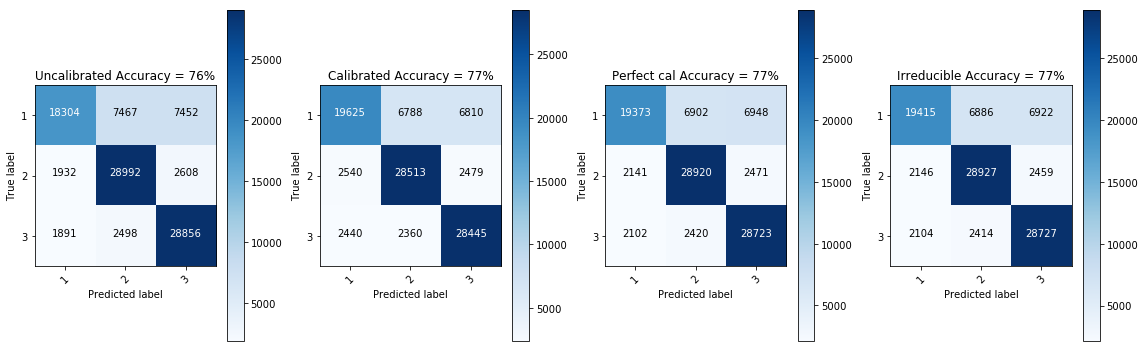

In [16]:
perfect_posterior_test = perfect_calibration(X_test, a, b, mg)

true_posterior_test = mg.posterior(X_test)

fig = plt.figure()
for i, (method, predictions) in enumerate((('Uncalibrated', P_nb_test),
                                           ('Calibrated', P_cal_test),
                                           ('Perfect cal', perfect_posterior_test),
                                           ('Irreducible', true_posterior_test))):
    print("{} Brier score = {:.2e}".format(method, mean_squared_error(Y_bin_test, predictions)))  
    ax = fig.add_subplot(1, 4, i+1)
    cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))

    plot_confusion_matrix(cm, classes=['1', '2', '3'], fig=fig, ax=ax,
                          title="{} Accuracy = {:.0f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))

## 3.b. Predicted posteriors

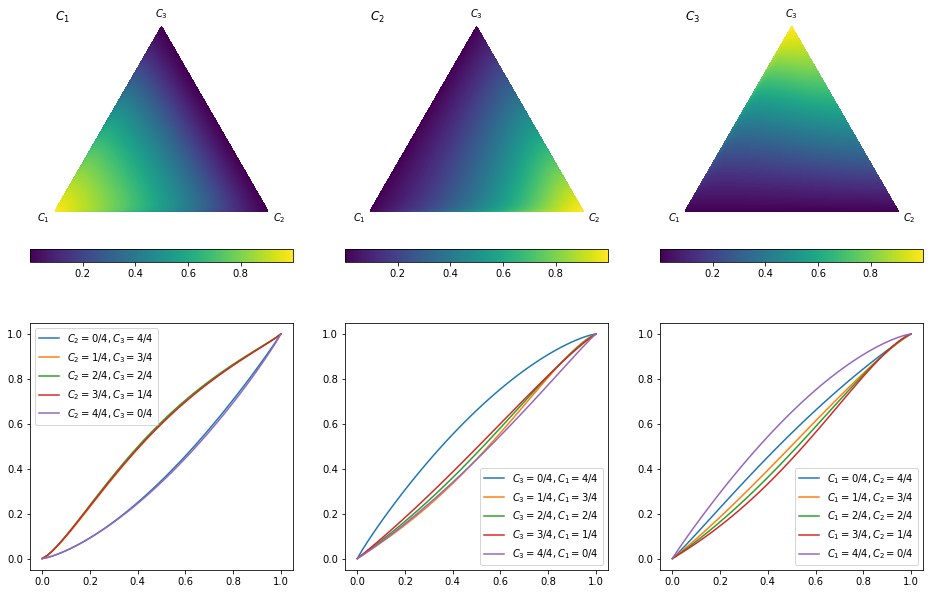

In [17]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: calibrator.predict_proba(np.log(np.clip(x.reshape(1,-1), eps, 1)))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

# 4. Calibration with Artificial Neural Network log scores

Calibrator parameters
{
  "alpha": 1e-05,
  "max_iter": 200,
  "n_iter_no_change": 10,
  "epsilon": 1e-08,
  "shuffle": true,
  "solver": "lbfgs",
  "validation_fraction": 0.1,
  "batch_size": "auto",
  "random_state": 1,
  "tol": 0.0001,
  "activation": "relu",
  "learning_rate": "constant",
  "nesterovs_momentum": true,
  "learning_rate_init": 0.001,
  "beta_1": 0.9,
  "early_stopping": false,
  "warm_start": false,
  "momentum": 0.9,
  "power_t": 0.5,
  "hidden_layer_sizes": 10,
  "beta_2": 0.999,
  "verbose": false
}


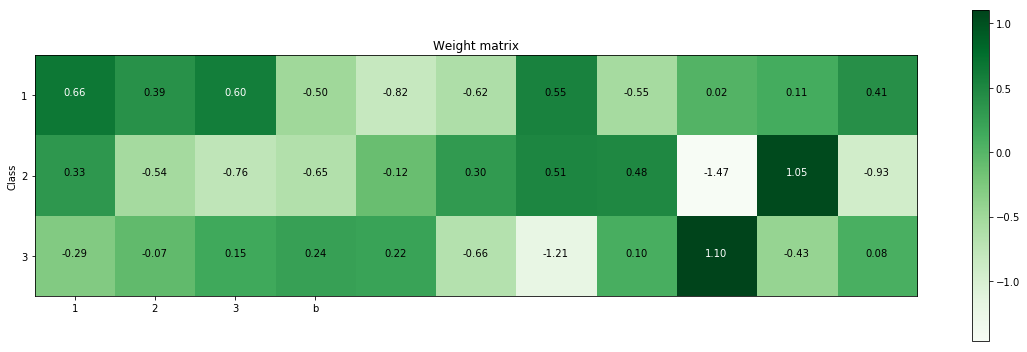

In [18]:
eps = np.finfo(P_nb.dtype).eps
log_P_nb = np.log(np.clip(P_nb, eps, 1))

from sklearn.neural_network import MLPClassifier
calibrator =  MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(10), random_state=1).fit(log_P_nb, Y)

print('Calibrator parameters')
import json
print(json.dumps(calibrator.get_params(), indent=2))

log_P_nb_test = np.log(np.clip(P_nb_test, eps, 1))

P_cal_test = calibrator.predict_proba(log_P_nb_test)

Y_cal_test = calibrator.predict(log_P_nb_test)

if hasattr(calibrator, 'coef_'):
    plot_weight_matrix(calibrator.coef_, calibrator.intercept_, classes=['1', '2', '3'])
elif hasattr(calibrator, 'coefs_'):
    plot_weight_matrix(calibrator.coefs_[-1].T, calibrator.intercepts_[-1], classes=['1', '2', '3'])

Uncalibrated Brier score = 1.16e-01
Calibrated Brier score = 1.11e-01
Perfect cal Brier score = 1.10e-01
Irreducible Brier score = 1.09e-01


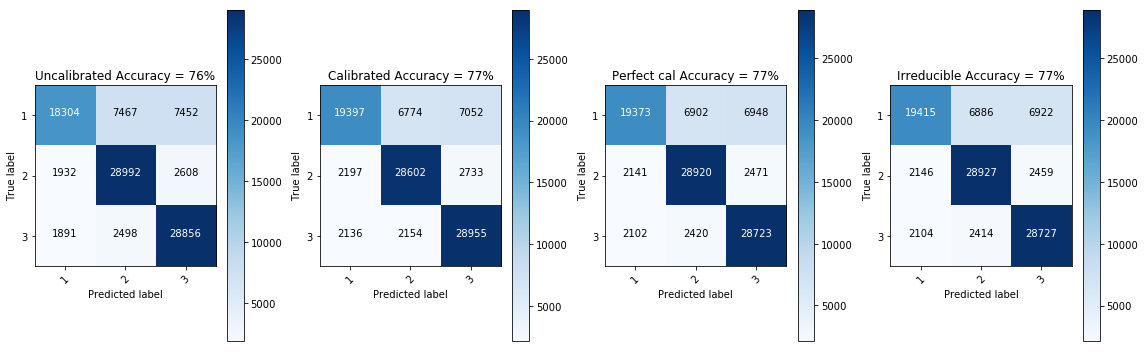

In [19]:
perfect_posterior_test = perfect_calibration(X_test, a, b, mg)

true_posterior_test = mg.posterior(X_test)

fig = plt.figure()
for i, (method, predictions) in enumerate((('Uncalibrated', P_nb_test),
                                           ('Calibrated', P_cal_test),
                                           ('Perfect cal', perfect_posterior_test),
                                           ('Irreducible', true_posterior_test))):
    print("{} Brier score = {:.2e}".format(method, mean_squared_error(Y_bin_test, predictions)))  
    ax = fig.add_subplot(1, 4, i+1)
    cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))

    plot_confusion_matrix(cm, classes=['1', '2', '3'], fig=fig, ax=ax,
                          title="{} Accuracy = {:.0f}%".format(method, (Y_test == np.argmax(predictions, axis=1)).mean()*100))

## 4.b. Predicted posteriors

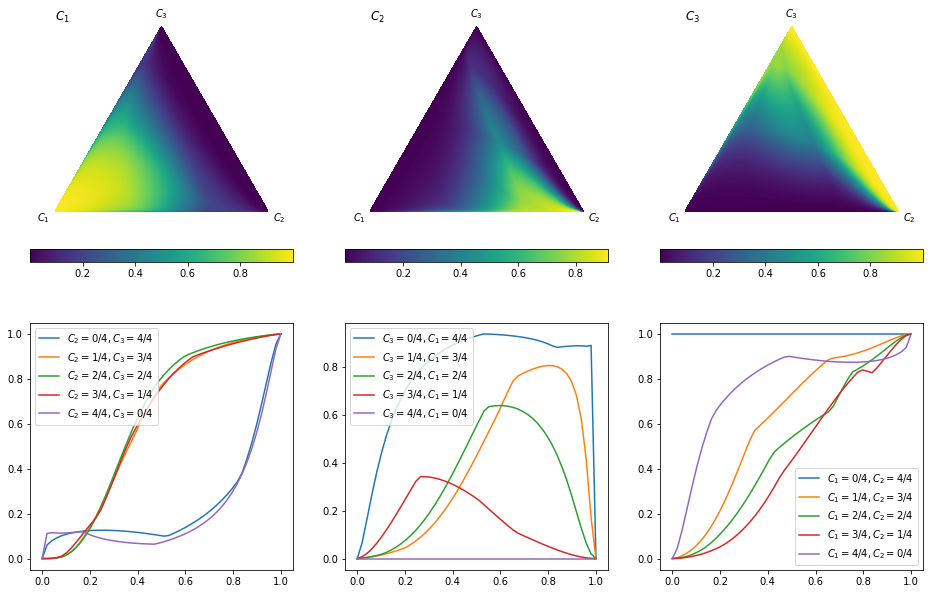

In [20]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: calibrator.predict_proba(np.log(np.clip(x.reshape(1,-1), eps, 1)))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)